In [1]:
#Importing the basic librarires

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import joblib

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv('../data/Walmart.csv')

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
# Reframing the columns

df.Date=pd.to_datetime(df.Date)

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year


df.drop(['Date'], axis=1, inplace=True)

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [4]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [5]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [6]:
# Define categorical and numerical features

cf = ['Store', 'month', 'weekday', 'year', 'Holiday_Flag']
nf = ['CPI', 'Unemployment', 'Temperature', 'Fuel_Price']

In [7]:
# Convert categorical columns to strings

df[cf] = df[cf].astype(str)

In [8]:
#Checking the stats of all the columns

df.describe()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,7.999151
std,5.643666e+05,18.444933,0.459020,39.356712,1.875885
min,2.099862e+05,-2.060000,2.472000,126.064000,3.879000
25%,5.533501e+05,47.460000,2.933000,131.735000,6.891000
50%,9.607460e+05,62.670000,3.445000,182.616521,7.874000
75%,1.420159e+06,74.940000,3.735000,212.743293,8.622000
max,3.818686e+06,100.140000,4.468000,227.232807,14.313000


In [9]:
#Removal of any Duplicate rows

df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [10]:
#Check for null elements

df.isnull().sum().sort_values()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
weekday         0
month           0
year            0
dtype: int64

In [11]:
# One-Hot Encoding for categorical features
df3 = df.copy(deep=True)

df_categorical = pd.get_dummies(df3[cf], drop_first=False)

df3 = pd.concat([df3[nf], df_categorical, df['Weekly_Sales']], axis=1)

print(df3.shape)

(6435, 74)


In [12]:
#Removal of outlier:

df1 = df3.copy(deep=True)

features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
    
print(f'The dataset had {df3.shape[0]}')
print(f'The dataset now has {df1.shape[0]}')

The dataset had 6435
The dataset now has 5953


In [13]:
#Splitting the data intro training & testing sets

df = df1.copy(deep=True)
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)
Train_X.reset_index(drop=True,inplace=True)

print(f'Original set {X.shape}')
print(f'Training set {Train_X.shape}')
print(f'Testing  set {Test_X.shape}')

Original set (5953, 73)
Training set (4762, 73)
Testing  set (1191, 73)


In [14]:
# Save the processed DataFrame to a new CSV file
df.to_csv('../data/Walmart-updated.csv', index=False)

In [15]:
#Feature Scaling (Standardization)

std = StandardScaler()

Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)

Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)

In [16]:
#Evaluate our models through function

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([2,2]), columns=['Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)

def Evaluate(n, pred1,pred2):
    
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6] ,dpi=300)
    
    for e,i in enumerate(rc):
        plt.subplot(1,len(rc),e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print(f'Root Mean Squared Error (RMSE) on Training set {round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)}')
    print(f'Root Mean Squared Error (RMSE) on Testing  set {round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)}')
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

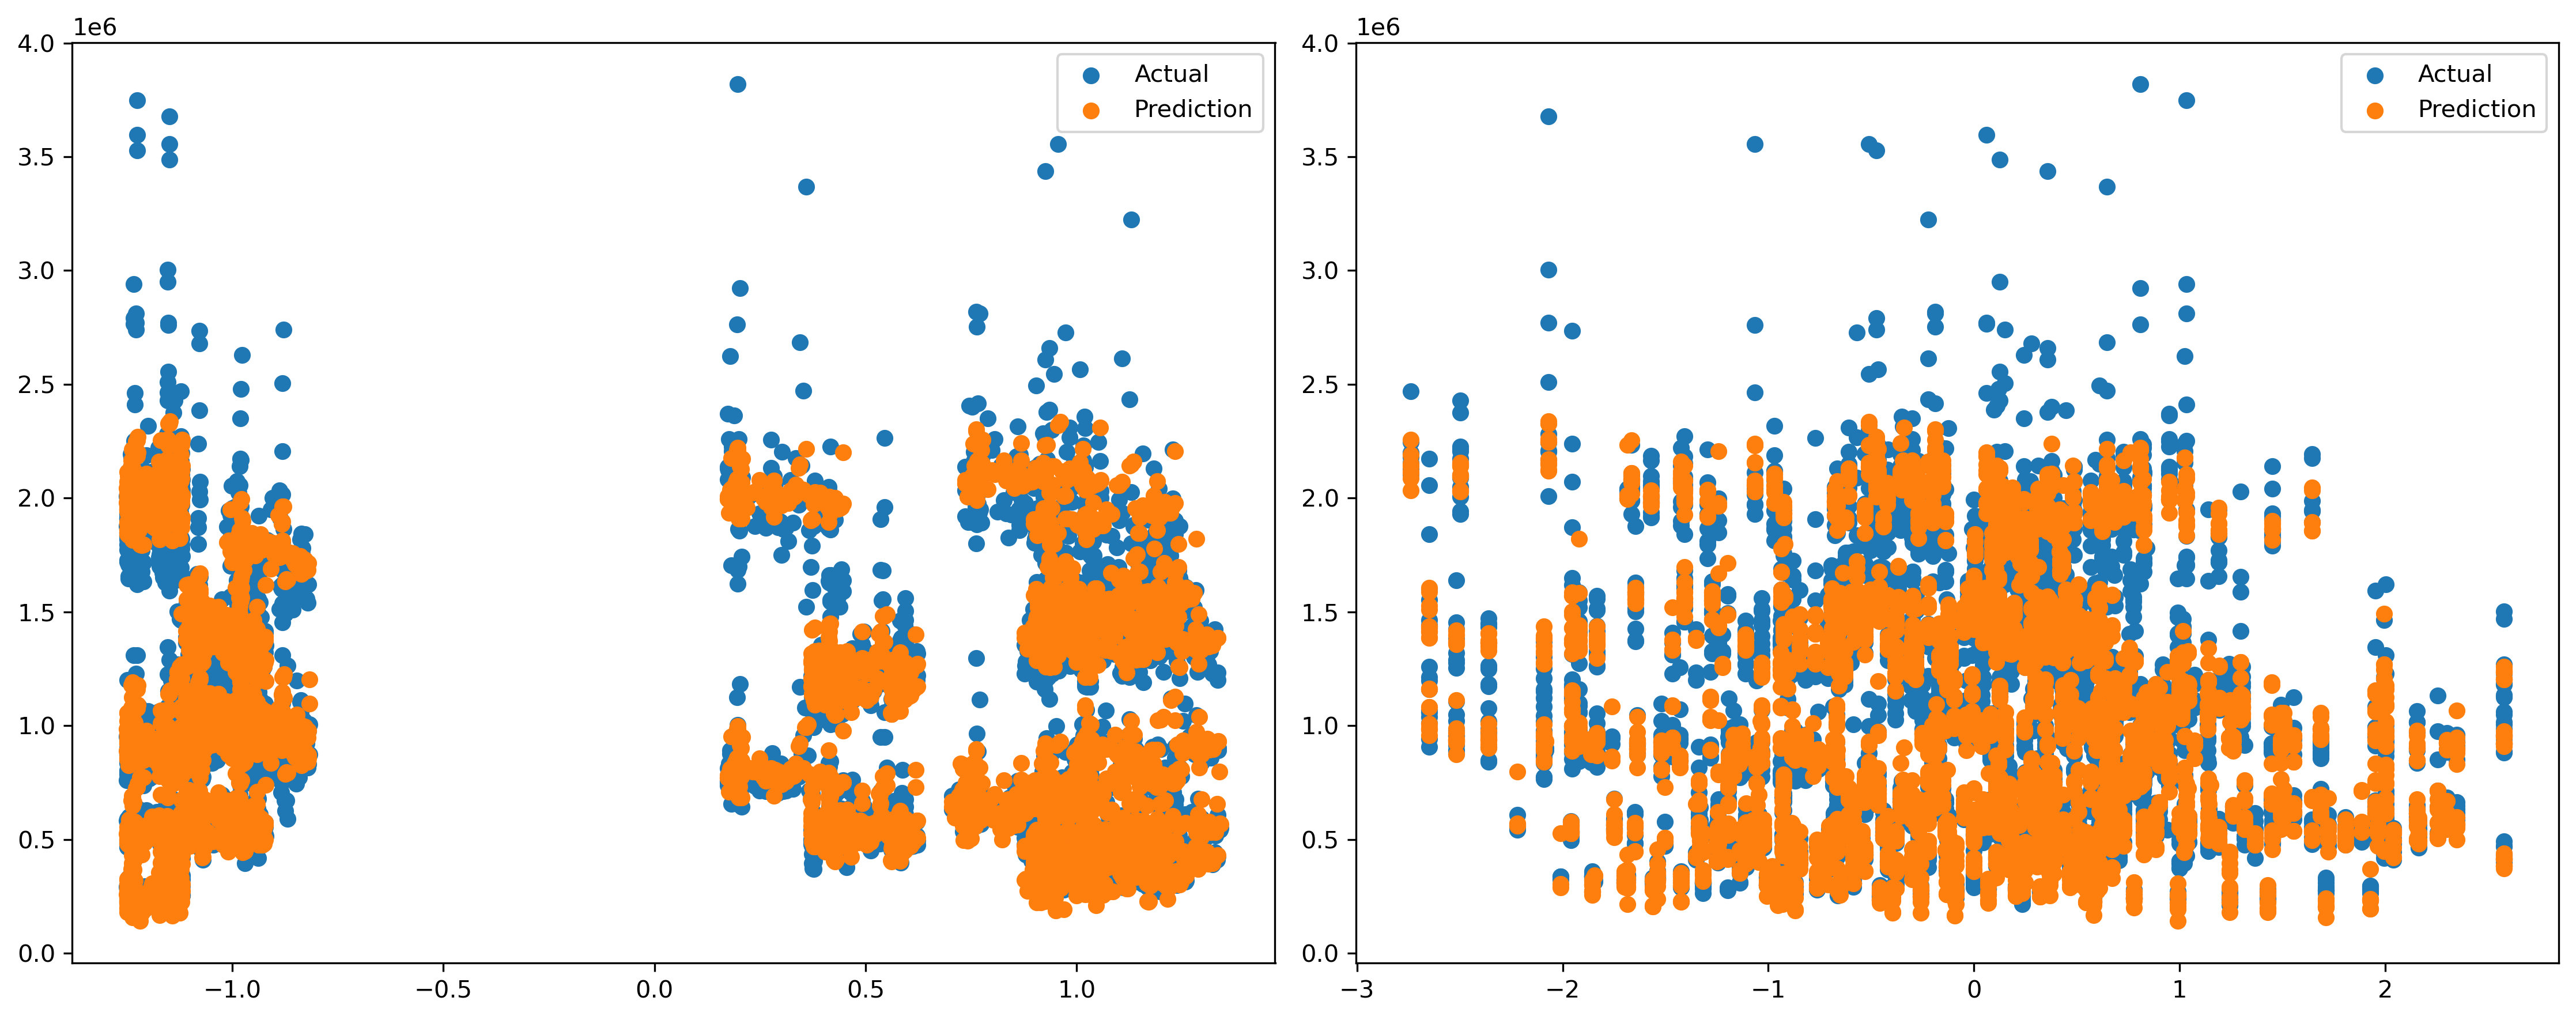

Root Mean Squared Error (RMSE) on Training set 150235.68971304028
Root Mean Squared Error (RMSE) on Testing  set 143828.94830818716


In [17]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

Evaluate(0, pred1, pred2)

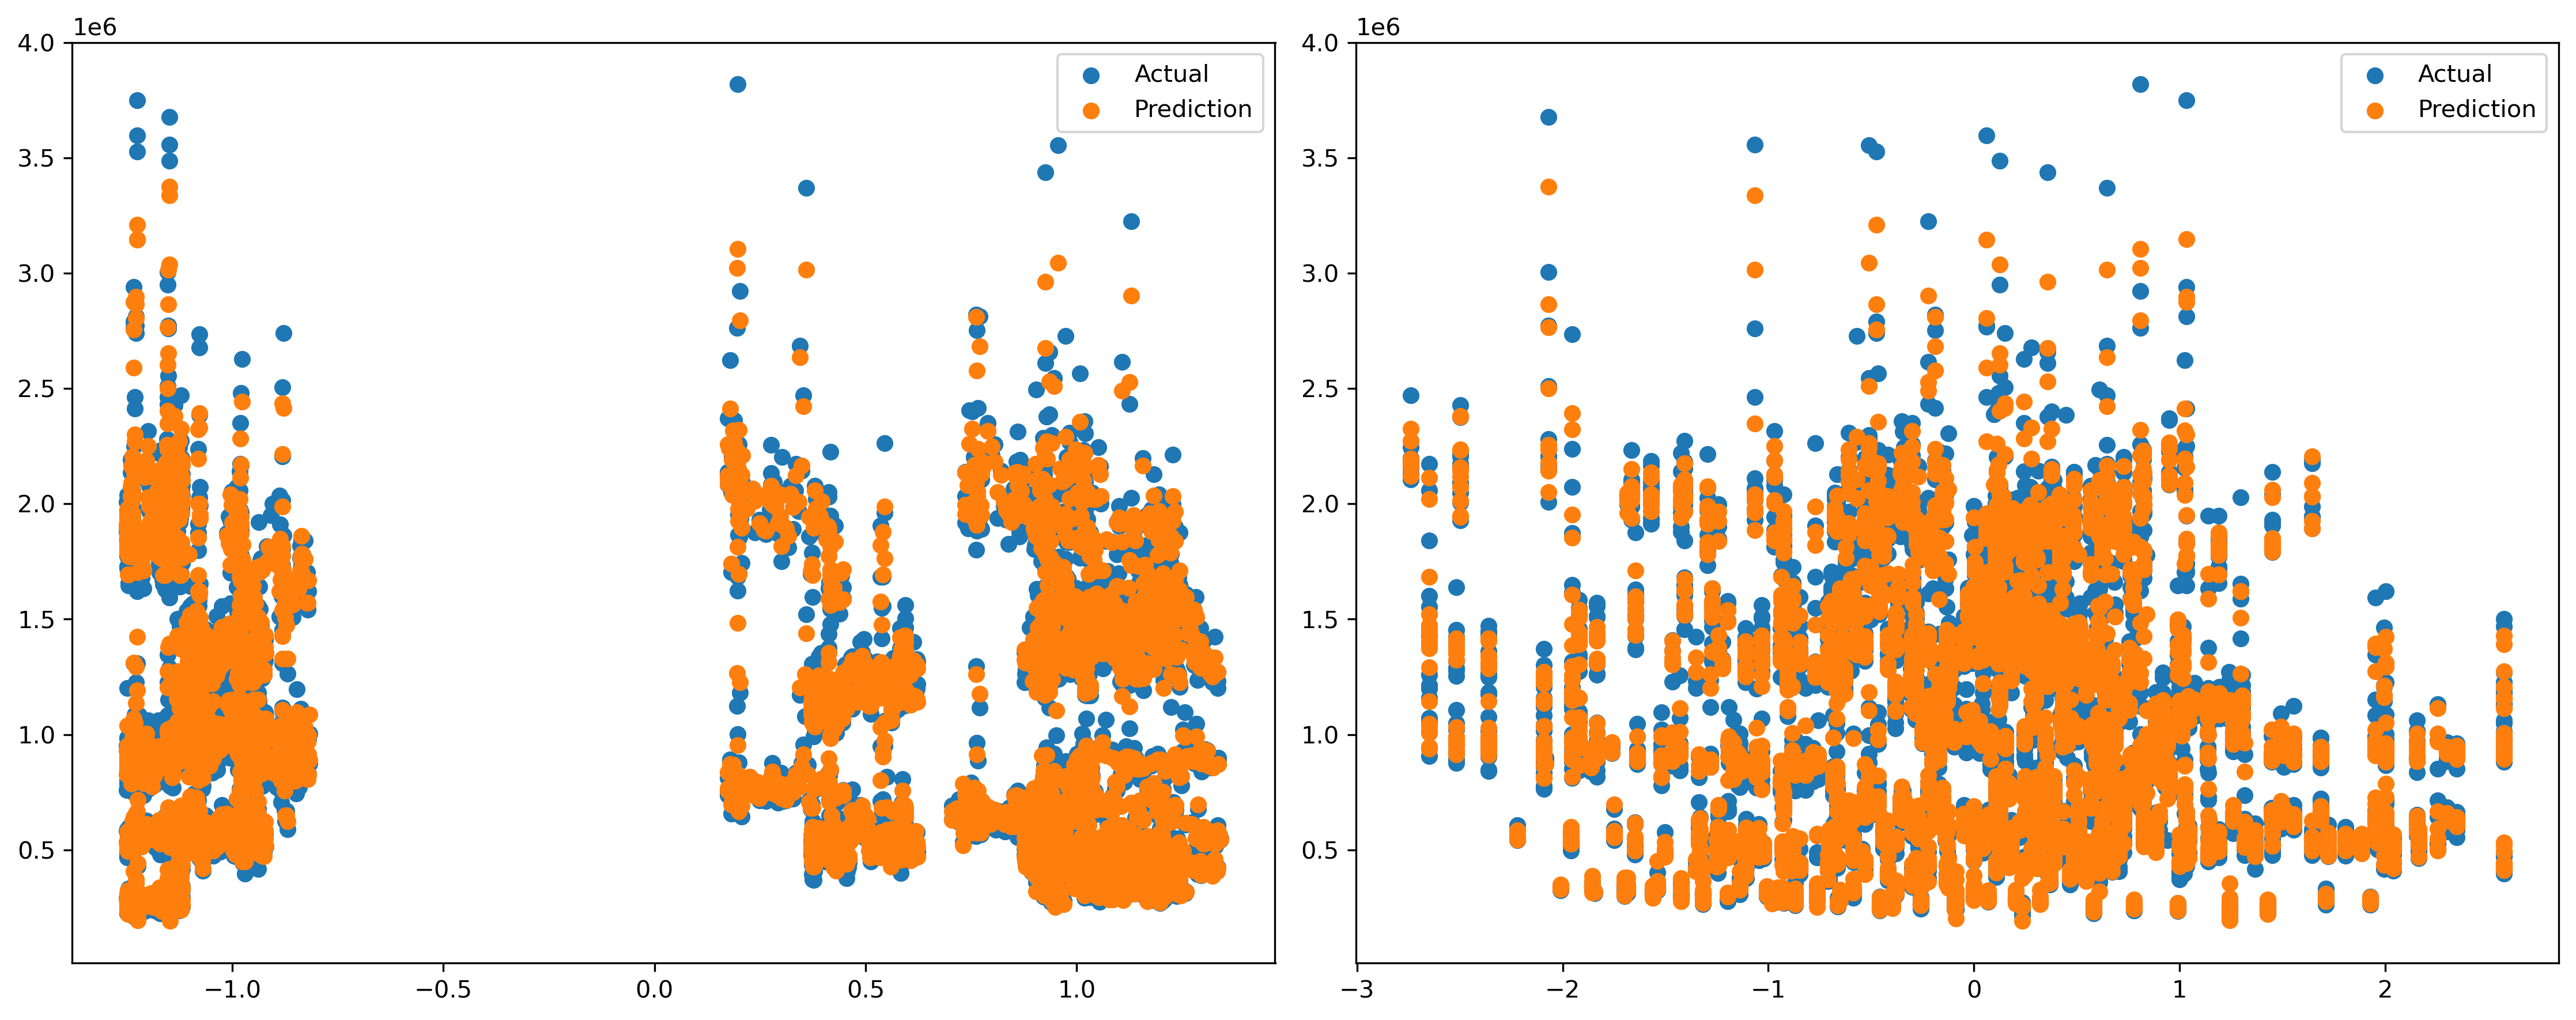

Root Mean Squared Error (RMSE) on Training set 58483.514845021244
Root Mean Squared Error (RMSE) on Testing  set 106131.1088114067


In [18]:
# Initialize XGBoost with early stopping parameters

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    early_stopping_rounds=50,
    eval_metric='rmse'
)

xgb_model.fit(
    Train_X_std, 
    Train_Y,
    eval_set=[(Test_X_std, Test_Y)],
    verbose=False
)
train_preds_xgb = xgb_model.predict(Train_X_std)
test_preds_xgb = xgb_model.predict(Test_X_std)

Evaluate(1, train_preds_xgb, test_preds_xgb)

In [19]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression', 'XGBoost']
EMC.columns = ['Training RMSE', 'Testing RMSE']
EMC.style.format('{:,.2f}').background_gradient(cmap='Reds')

,Training RMSE,Testing RMSE
Multiple Linear Regression,"150,235.69","143,828.95"
XGBoost,"58,483.51","106,131.11"


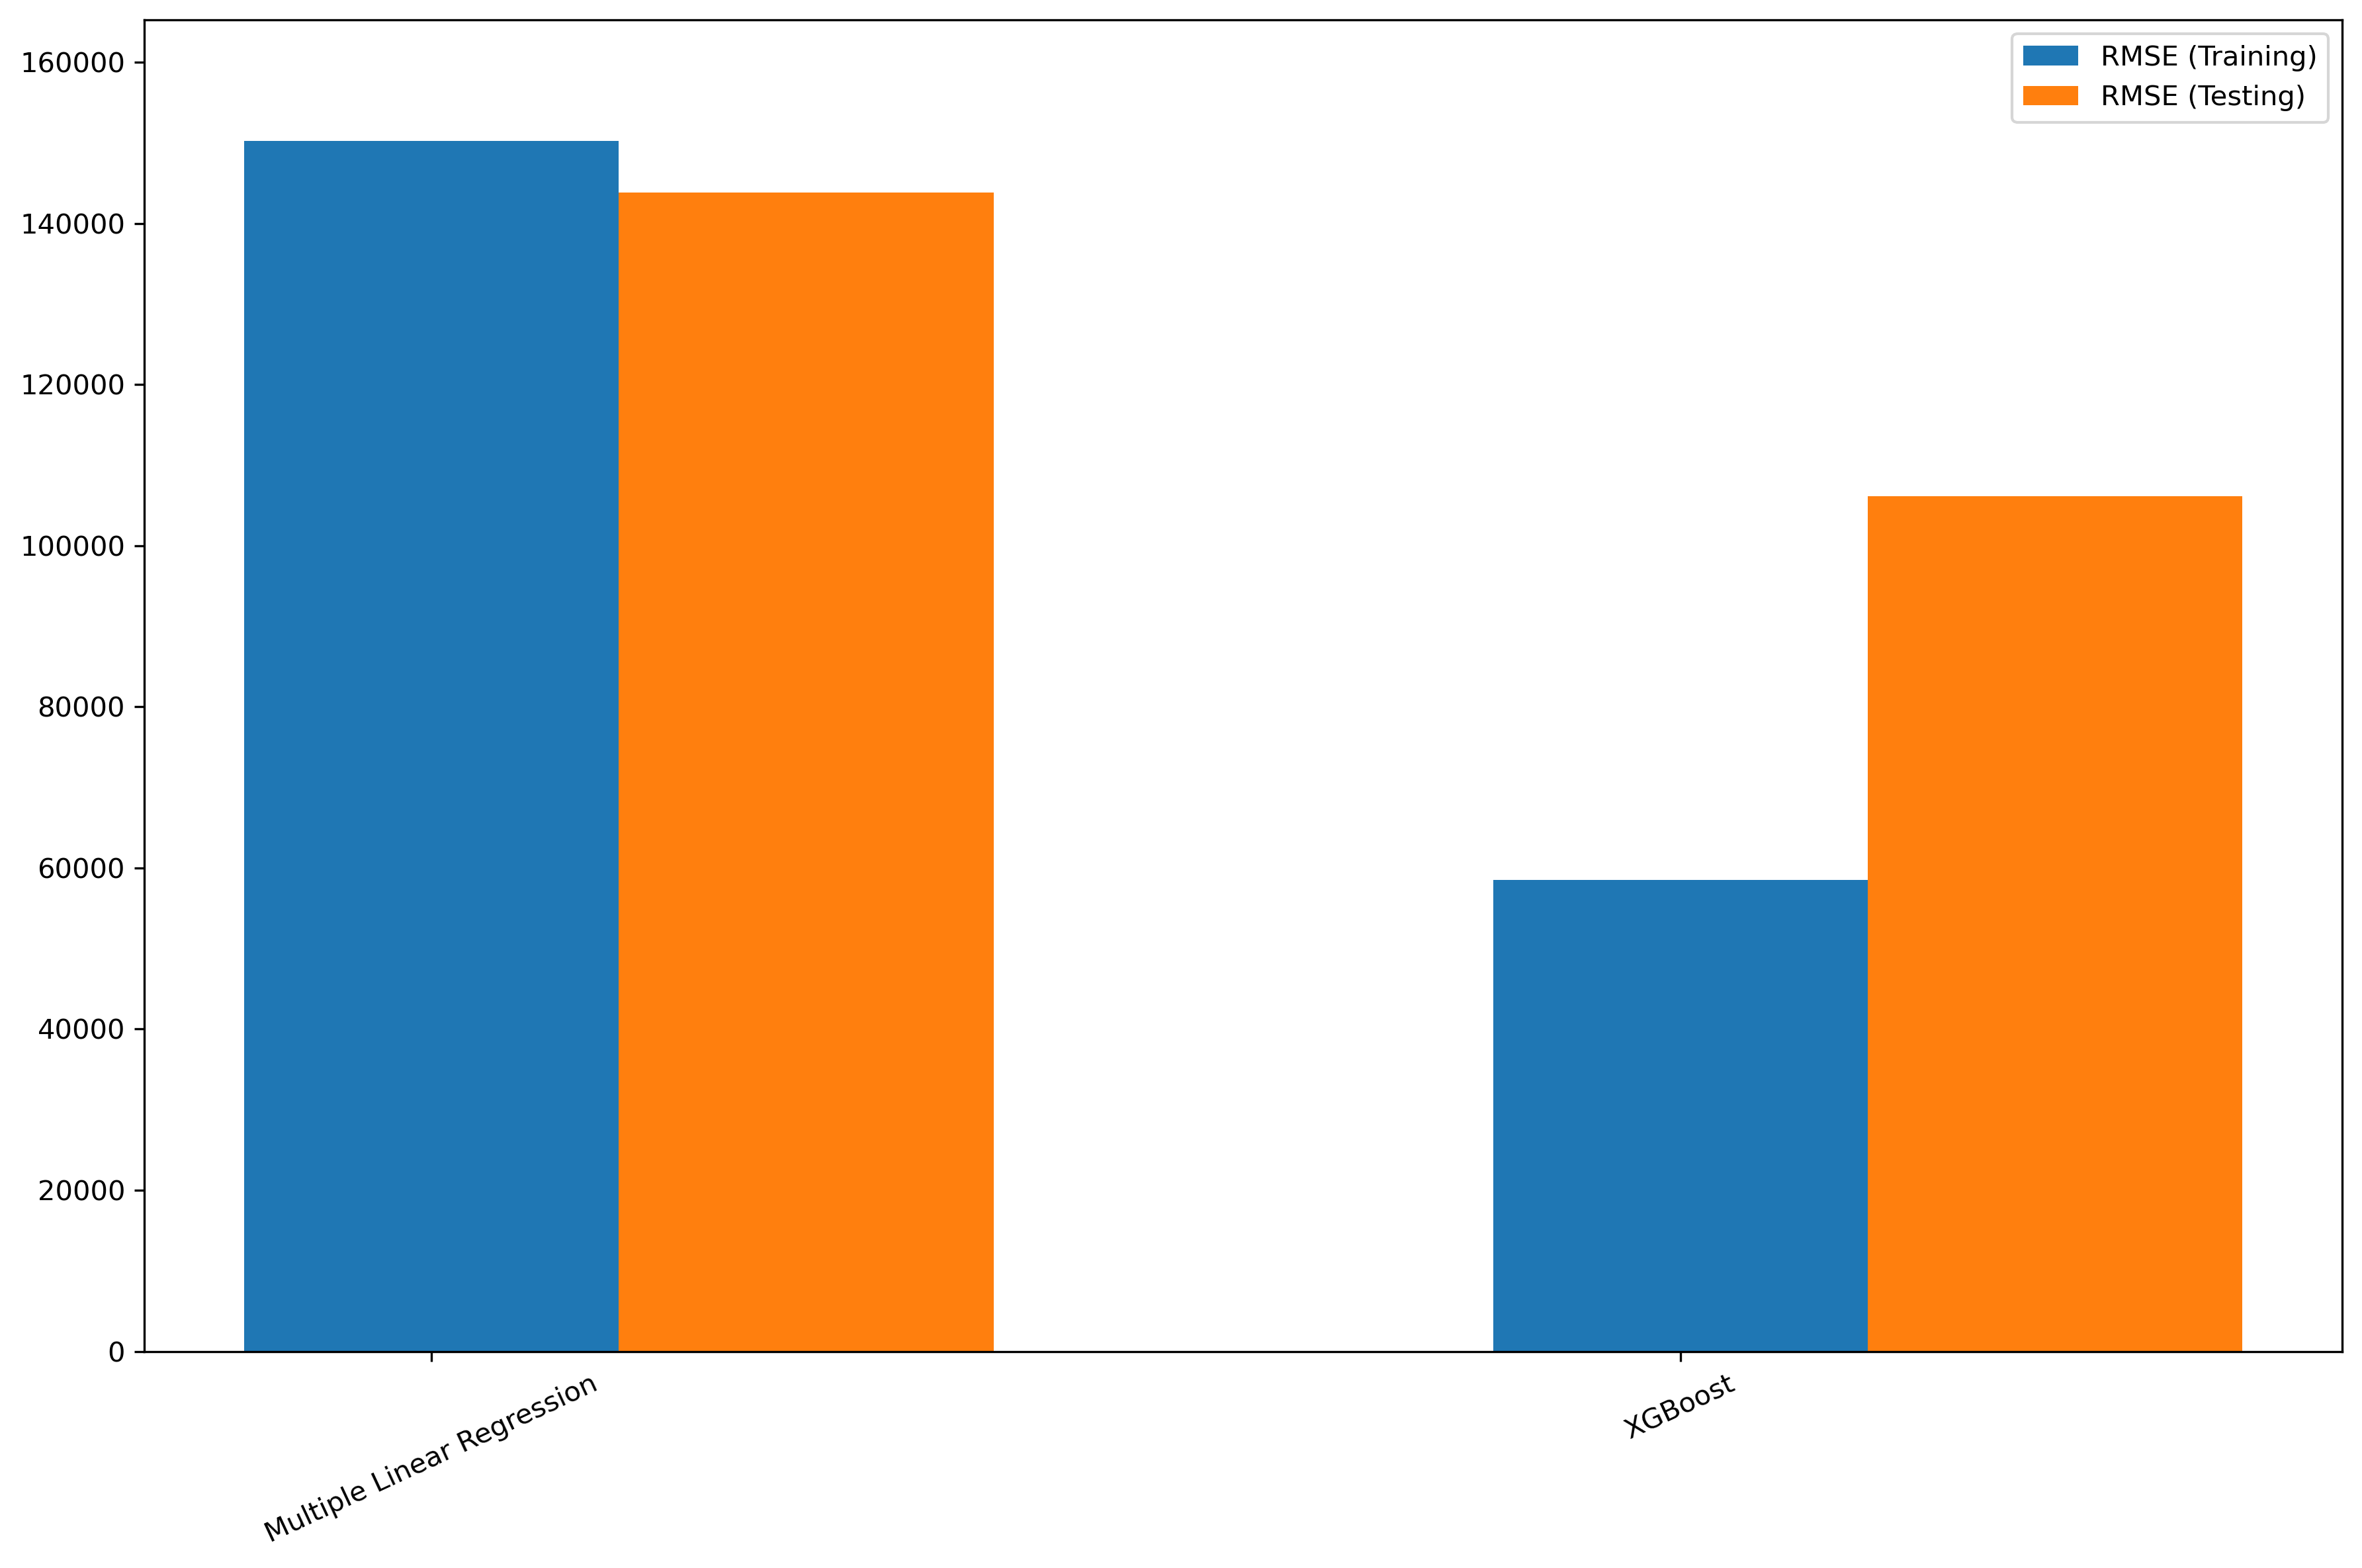

In [20]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=2
plt.figure(figsize=(12, 8), dpi=300)
plt.bar(np.arange(s), Model_Evaluation_Comparison_Matrix[cc[0]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(s)+0.3, Model_Evaluation_Comparison_Matrix[cc[1]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(s),EMC.index, rotation =25)
plt.legend()
plt.ylim(0, Model_Evaluation_Comparison_Matrix.values.max() * 1.1)
plt.tight_layout()
plt.show()

In [21]:
# Save Linear Regression model
joblib.dump(MLR, 'linear_regression_model.pkl')

# Save XGBoost model
joblib.dump(xgb_model, 'xgboost_model.pkl')

print("Models saved successfully.")

Models saved successfully.
